In [1]:
import os
import re

import pathlib
from pathlib import Path

import sqlite3

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Helper (support)
from support import input_helper

In [3]:
mpl.rcParams['figure.figsize'] = (16, 9)

In [4]:
ROOT_DIR = "RawData"

In [5]:
sns.set_style("ticks")
sns.color_palette("colorblind")
sns.set_context("notebook", font_scale=1)

In [6]:
pd.set_option('precision', 2)

* BE = Belgium
* FR = France
* EU = Europe
* FG = Flat Glass
* ArchFG = Architectural Flat Glass

# Upload Datasets

In [7]:
BE_data = input_helper.get_data('BE_RawData_VPython.xlsx', directory=ROOT_DIR)
FR_data = input_helper.get_data('FR_RawData_VPython.xlsx', directory=ROOT_DIR)
EU_data = input_helper.get_data('EU_RawData_VPython.xlsx', directory=ROOT_DIR)

In [8]:
print("BE_data, sheet names = \n {}\n".format(BE_data.sheet_names))
print("FR_data, sheet names = \n {}\n".format(FR_data.sheet_names))
print("EU_data, sheet names = \n {}\n".format(EU_data.sheet_names))

BE_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'FlatGlassInd_GlassInd', 'RawMat_GlassInd_ABS']

FR_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'RawMat_Intensity', 'Energy_Intensity', 'RawMat_FlatGlass_ABS', 'emissions']

EU_data, sheet names = 
 ['stock', 'consumption', 'prod', 'import', 'export', 'workforce', 'EnergyUse', 'pollution', 'production costs']



# Flat glass production in France and Belgium

## Creating one dataframe for flat glass flows

In [9]:
# Creating a DataFrame only with production data
FR_Prod = FR_data.parse('prod').set_index('year')
BE_Prod = BE_data.parse('prod').set_index('year')

# Creating a new DataFrame for Belgian and French flat glass production
BE_FR_FGProd = pd.concat([FR_Prod['flat glass, kt'],
                          BE_Prod['flat glass, kt']],
                         axis=1, keys=['FR [kt]', 'BE [kt]'])

BE_FR_FGProd

,FR [kt],BE [kt]
year,,
1945,108.3,NaN
1946,173.8,NaN
1947,198.3,NaN
1948,220.2,NaN
1949,191.3,NaN
...,...,...
2016,NaN,NaN
2017,NaN,NaN
2018,NaN,NaN


In [10]:
# Creating a DataFrame with import and export data
FR_Imp = FR_data.parse('import').set_index('year')
FR_Exp = FR_data.parse('export').set_index('year')

BE_Imp = BE_data.parse('import').set_index('year')
BE_Exp = BE_data.parse('export').set_index('year')

In [11]:
# Creating a unique DataFrame for French and Belgian flat glass flows
BE_FR = pd.concat([FR_Prod['flat glass, kt'], BE_Prod['flat glass, kt'],
                   FR_Imp['flat glass, kt'], BE_Imp['flat glass, kt'],
                   FR_Exp['flat glass, kt'], BE_Exp['flat glass, kt']],
                  axis=1, keys=[('Production [kt]', 'France'),
                                ('Production [kt]', 'Belgium'),
                                ('Import [kt]', 'France'), 
                                ('Import [kt]', 'Belgium'),
                                ('Export [kt]', 'France'), 
                                ('Export [kt]', 'Belgium')],
                  names=['Info', 'Country']).stack()

BE_FR = BE_FR.unstack()

In [12]:
BE_FR

Info    Export [kt]         Import [kt]        Production [kt]       
Country     Belgium  France     Belgium France         Belgium France
year                                                                 
1945.0          NaN     NaN         NaN    NaN             NaN  108.3
1946.0          NaN     NaN         NaN    NaN             NaN  173.8
1947.0          NaN     NaN         NaN    NaN             NaN  198.3
1948.0          NaN     NaN         NaN    NaN             NaN  220.2
1949.0          NaN     NaN         NaN    NaN             NaN  191.3
...             ...     ...         ...    ...             ...    ...
2016.0       499.79  300.84      216.27  370.0             NaN    NaN
2017.0       547.19  333.31      230.96  401.0             NaN    NaN
2018.0       547.76  349.18      228.65  355.0             NaN    NaN
2019.0       986.33  451.42      254.22  352.0             NaN    NaN
2020.0          NaN     NaN         NaN  349.0             NaN    NaN

[76 rows x 6 columns]

## Production of flat glass

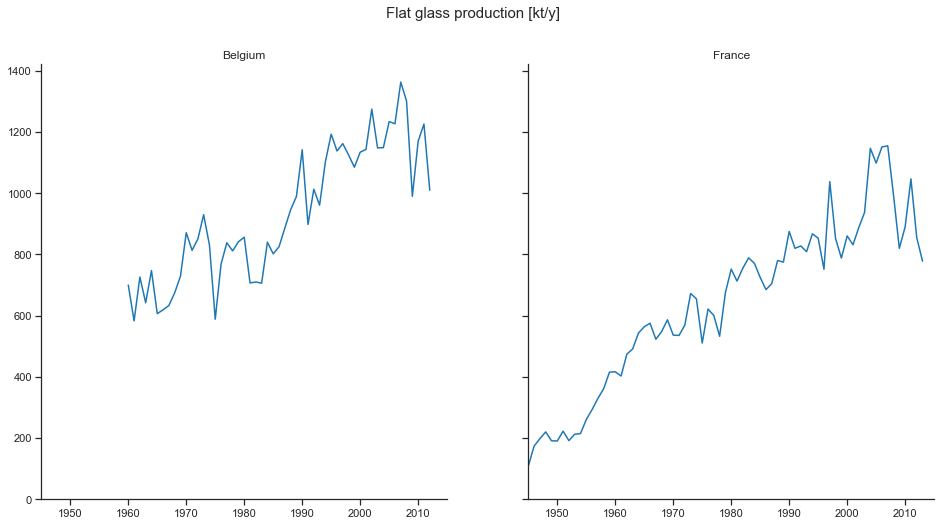

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 8), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Production [kt]'].columns)):

    ax.plot(BE_FR['Production [kt]'].index, BE_FR['Production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

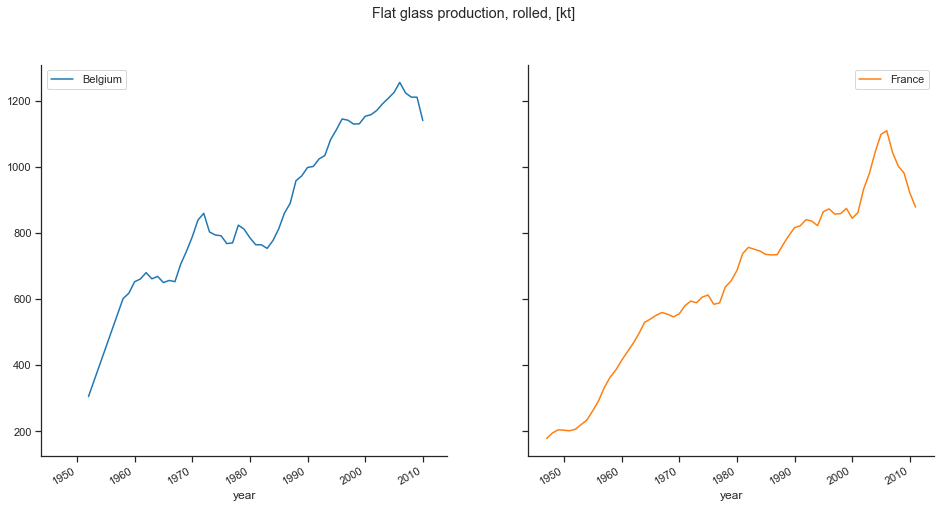

In [14]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass production
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of flat glass

<font color='red'>Watch out! For Belgium, data for import and export are not sufficiently reliable to provide a clear picture of flat glass consumption.</font>

<font color='red'>If a comprehensive set of data can be collected, it will be possible to better characterise the current stock.</font>

In [15]:
BE_FR = BE_FR.stack()

BE_FR['Import Ratio'] = BE_FR['Import [kt]'] / BE_FR['Production [kt]']
BE_FR['Export Ratio'] = BE_FR['Export [kt]'] / BE_FR['Production [kt]']

BE_FR = BE_FR.unstack()

In [16]:
# Interpolation for missing data
cols = [x for x in BE_FR.columns if x[0] in ['Import Ratio', 'Export Ratio']]

BE_FR[cols] = (BE_FR[cols].interpolate(method='linear'))

In [17]:
BE_FR.loc[1950:1960, cols]

Info    Import Ratio           Export Ratio       
Country      Belgium    France      Belgium France
year                                              
1950.0           NaN       NaN          NaN   0.29
1951.0           NaN       NaN          NaN   0.28
1952.0           NaN  5.99e-03          NaN   0.27
1953.0           NaN  5.33e-03          NaN   0.26
1954.0           NaN  4.99e-02          NaN   0.24
1955.0           NaN  4.64e-02          NaN   0.20
1956.0           NaN  4.47e-02          NaN   0.17
1957.0           NaN  4.30e-02          NaN   0.15
1958.0           NaN  4.14e-02          NaN   0.18
1959.0           NaN  3.97e-02          NaN   0.21
1960.0          0.02  3.80e-02         0.66   0.24

In [18]:
ratios = ['Import', 'Export']
countries = ['Belgium', 'France']

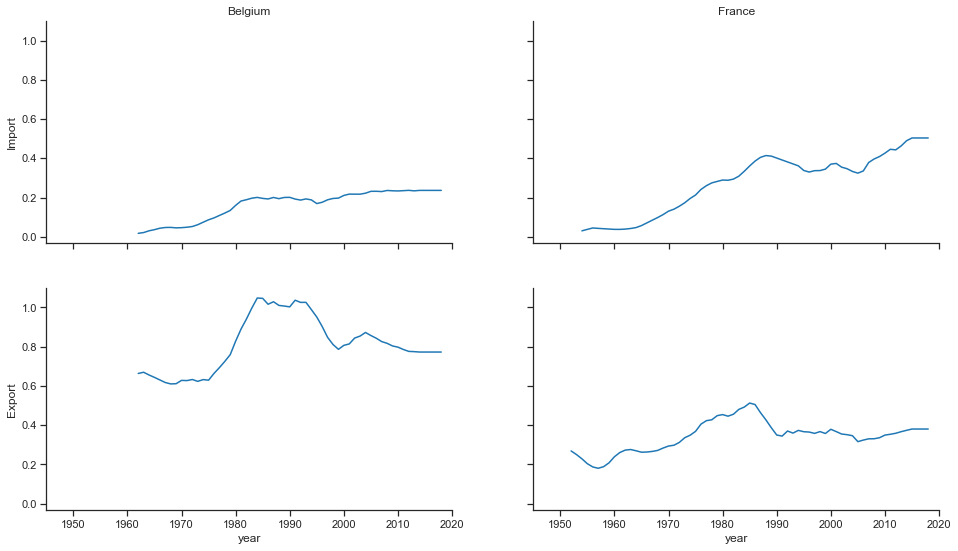

In [19]:
nrows = len(ratios)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(16,9))
for row, ratio in enumerate(ratios):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(ratio)
        (BE_FR[(f"{ratio} Ratio", country)]
         .rolling(5, center = True).mean()
         .plot(ax=ax)
        )
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

In [20]:
BE_FR = BE_FR.stack()

BE_FR['Consumption [kt]'] = (BE_FR['Production [kt]']
                                         + BE_FR['Import Ratio'] 
                                         * BE_FR['Production [kt]']
                                         - BE_FR['Export Ratio'] 
                                         * BE_FR['Production [kt]'])

BE_FR = BE_FR.unstack()

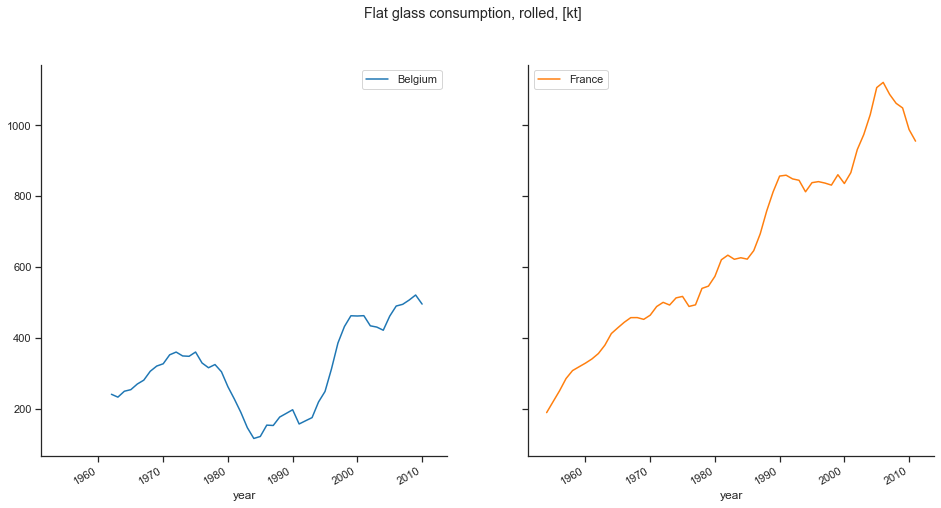

In [21]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Flat glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Production of architectural flat glass

In [22]:
# Share of building glass in the French production of flat glass

ShareFR = FR_Prod[['bldg glass/flat glass, %']].dropna()

print(ShareFR.isnull().sum())
ShareFR

bldg glass/flat glass, %    0
dtype: int64


,"bldg glass/flat glass, %"
year,
1947,0.90
1952,0.80
1962,0.68
1968,0.50
1980,0.50
1994,0.50
2002,0.52
2004,0.49


In [23]:
# Estimating parameters a and b of the regression lines

ShareFR['Trend1'] = ShareFR['bldg glass/flat glass, %'][:4]
ShareFR['Trend2'] = ShareFR['bldg glass/flat glass, %'][-5:]

ShareFR = ShareFR.reset_index()

x1 = list(ShareFR['year'][:4])
y1 = list(ShareFR['Trend1'][:4])
a1, b1 = np.polyfit(x1, y1, 1)

x2 = list(ShareFR['year'][-5:])
y2 = list(ShareFR['Trend2'][-5:])
a2, b2 = np.polyfit(x2, y2, 1)

ShareFR = ShareFR.set_index('year')

# Point of intersection of the two regression lines
xi = (b1-b2) / (a2-a1)
print(f'Approximate year of rate change: {xi:.0f}')

Approximate year of rate change: 1970


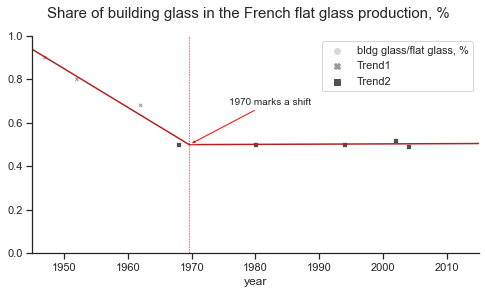

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.scatterplot(data=ShareFR, s=25, palette='Greys', ax=ax)

A = np.linspace(1945,xi)
ax.plot(A, a1*A+b1, color='firebrick')
B = np.linspace(xi,2020)
ax.plot(B, a2*B+b2, color='firebrick')

ax.axvline(xi ,linestyle='--', c='r', linewidth=0.5)

ax.annotate('1970 marks a shift', xy=(xi, a1*xi+b1), xycoords='data',
            xytext=(40, 40), textcoords='offset points', fontsize = 10,
            arrowprops=dict(arrowstyle='simple', facecolor='r'))

ax.set_ylim(0,1)
ax.set_xlim(1945,2015)
fig.suptitle('Share of building glass in the French flat glass production, %', 
             fontsize = 15)

sns.despine()
plt.show()

In [25]:
# Update dataset according to regression lines
BldgShare = FR_Prod[['bldg glass/flat glass, %']]

BldgShare = BldgShare.reset_index()

BldgShare.loc[(BldgShare['year'] < xi), 'bldg glass/flat glass, %'] \
    = round(a1 * BldgShare['year'] + b1, 2)

BldgShare.loc[(BldgShare['year'] >= xi), 'bldg glass/flat glass, %'] \
    = round(a2 * BldgShare['year'] + b2, 2)

BldgShare = BldgShare.set_index('year')
BldgShare

,"bldg glass/flat glass, %"
year,
1945,0.94
1946,0.92
1947,0.90
1948,0.88
1949,0.87
...,...
2016,0.50
2017,0.51
2018,0.51


In [26]:
# Estimate architectural flat glass production in France and Belgium
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('Architectural glass production [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * BldgShare['bldg glass/flat glass, %']
    )

In [27]:
BE_FR

Info    Export [kt]         Import [kt]        Production [kt]         \
Country     Belgium  France     Belgium France         Belgium France   
year                                                                    
1945.0          NaN     NaN         NaN    NaN             NaN  108.3   
1946.0          NaN     NaN         NaN    NaN             NaN  173.8   
1947.0          NaN     NaN         NaN    NaN             NaN  198.3   
1948.0          NaN     NaN         NaN    NaN             NaN  220.2   
1949.0          NaN     NaN         NaN    NaN             NaN  191.3   
...             ...     ...         ...    ...             ...    ...   
2016.0       499.79  300.84      216.27  370.0             NaN    NaN   
2017.0       547.19  333.31      230.96  401.0             NaN    NaN   
2018.0       547.76  349.18      228.65  355.0             NaN    NaN   
2019.0       986.33  451.42      254.22  352.0             NaN    NaN   
2020.0          NaN     NaN         NaN  349.0             NaN    NaN   

Info    Import Ratio        Export Ratio        Consumption [kt]         \
Country      Belgium France      Belgium France          Belgium France   
year                                                                      
1945.0           NaN    NaN          NaN    NaN              NaN    NaN   
1946.0           NaN    NaN          NaN    NaN              NaN    NaN   
1947.0           NaN    NaN          NaN    NaN              NaN    NaN   
1948.0           NaN    NaN          NaN    NaN              NaN    NaN   
1949.0           NaN    NaN          NaN    NaN              NaN    NaN   
...              ...    ...          ...    ...              ...    ...   
2016.0          0.24    0.5         0.77   0.38              NaN    NaN   
2017.0          0.24    0.5         0.77   0.38              NaN    NaN   
2018.0          0.24    0.5         0.77   0.38              NaN    NaN   
2019.0          0.24    0.5         0.77   0.38              NaN    NaN   
2020.0          0.24    0.5         0.77   0.38              NaN    NaN   

Info    Architectural glass production [kt]          
Country                             Belgium  France  
year                                                 
1945.0                                  NaN  101.80  
1946.0                                  NaN  159.90  
1947.0                                  NaN  178.47  
1948.0                                  NaN  193.78  
1949.0                                  NaN  166.43  
...                                     ...     ...  
2016.0                                  NaN     NaN  
2017.0                                  NaN     NaN  
2018.0                                  NaN     NaN  
2019.0                                  NaN     NaN  
2020.0                                  NaN     NaN  

[76 rows x 14 columns]

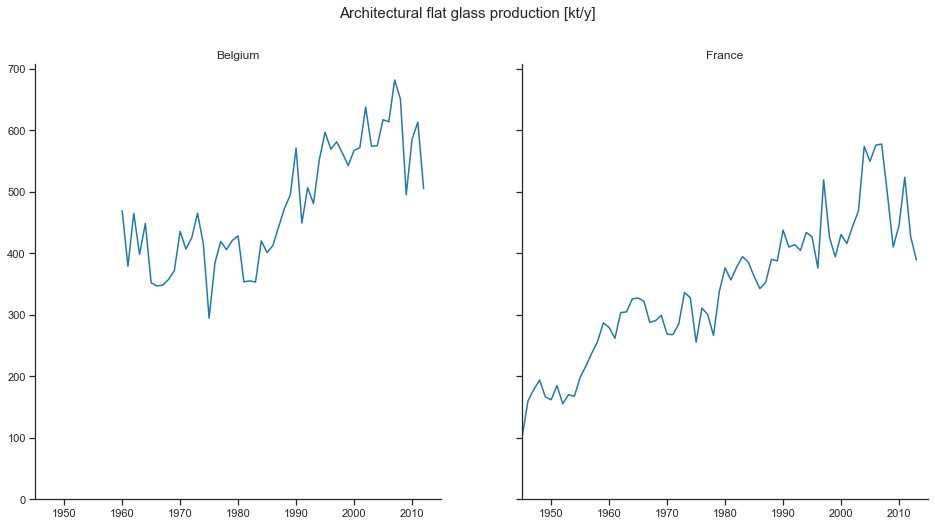

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         figsize=(16, 8), 
                         sharex=True, sharey=True)

for i, (ax, col) in enumerate(zip(axes.flatten(), 
                                  BE_FR['Architectural glass production [kt]']
                                  .columns)):

    ax.plot(BE_FR['Architectural glass production [kt]'].index, 
            BE_FR['Architectural glass production [kt]'][col])
    ax.set_title(col)
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    
fig.suptitle('Architectural flat glass production [kt/y]', fontsize = 15)
sns.despine()
plt.show()

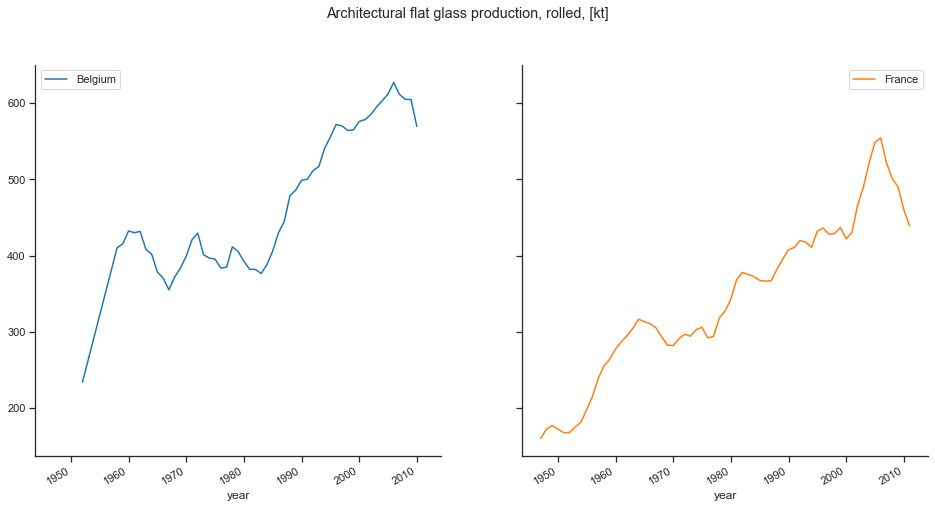

In [29]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass production [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Architectural flat glass production, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Consumption of architectural flat glass

In [30]:
BE_FR = BE_FR.stack()

BE_FR['Architectural glass consumption [kt]'] = (
    BE_FR['Architectural glass production [kt]']
    + BE_FR['Import Ratio'] * BE_FR['Architectural glass production [kt]']
    - BE_FR['Export Ratio'] * BE_FR['Architectural glass production [kt]']
)

BE_FR = BE_FR.unstack()

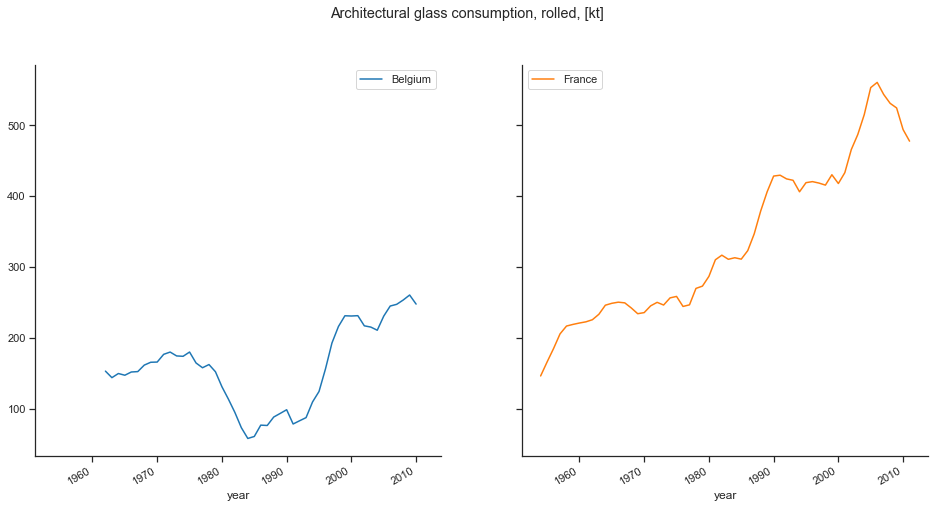

In [31]:
with sns.plotting_context("notebook"):
    # Linear interpolation for flat glass consumption
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['Architectural glass consumption [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title="Architectural glass consumption, rolled, [kt]")
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

# The CO2 emissions of the flat glass industry

## Carbon intensity of the flat glass production process

In [32]:
# Creating a DataFrame only with CO2 emission data
Emissions = FR_data.parse('emissions').set_index('year')

CO2_Intensity = Emissions[['CO2 glass ind, kg/t']].copy()
CO2_Intensity.rename(columns={'CO2 glass ind, kg/t':'CO2 [kg/t]'}, 
           inplace=True)

CO2_Intensity.dropna()

,CO2 [kg/t]
year,
1947,2100.0
1950,2050.0
1960,1725.0
1965,1525.0
1970,1340.0
1975,1075.0
1980,900.0
1985,800.0
1990,690.0


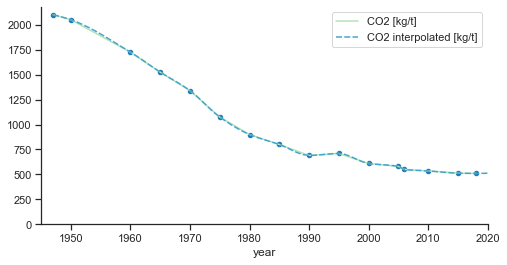

In [33]:
CO2_Intensity['CO2 interpolated [kg/t]'] = (
    CO2_Intensity['CO2 [kg/t]'].interpolate('pchip')
)

fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=CO2_Intensity, palette="GnBu")

ax.scatter(x=CO2_Intensity.index, y=CO2_Intensity['CO2 [kg/t]'],
           s=20)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Absolute CO2 emissions since 1945

In [34]:
# Estimating the CO2 emission related to flat glass production
for country in BE_FR['Production [kt]'].columns:
    BE_FR[('CO2, flat glass [kt]', country)] = (
        BE_FR[('Production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [35]:
# Estimating the CO2 emission related to architectural flat glass production
for country in BE_FR['Architectural glass production [kt]'].columns:
    BE_FR[('CO2, architectural glass [kt]', country)] = (
        BE_FR[('Architectural glass production [kt]', country)]
        * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000
    )

In [36]:
CO2_G = ['CO2, flat glass [kt]', 'CO2, architectural glass [kt]']
countries = ['Belgium', 'France']

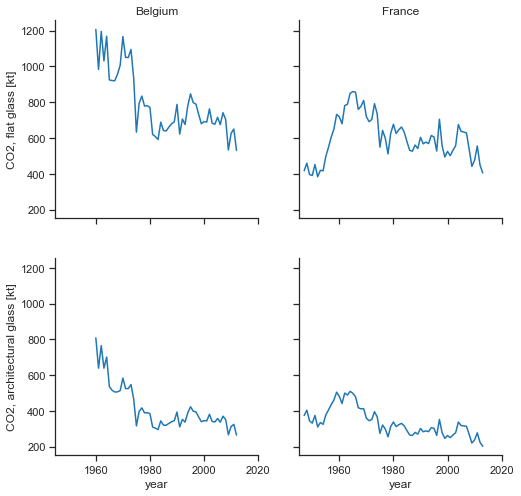

In [37]:
nrows = len(CO2_G)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,8))
for row, CO2 in enumerate(CO2_G):
    for col, country in enumerate(countries):
        ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(CO2)
        BE_FR[(f"{CO2}", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

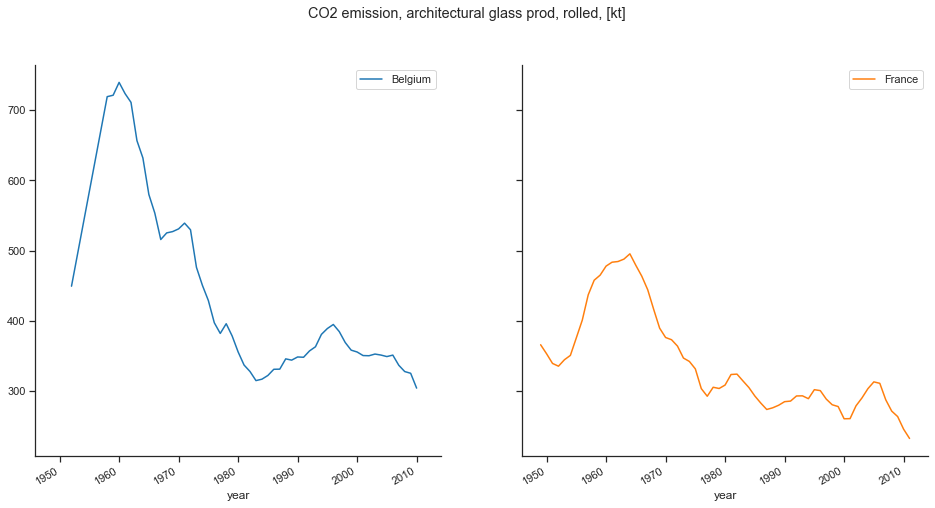

In [38]:
#Rolling and ploting the CO2 emission related to architectural glass prod
with sns.plotting_context("notebook"):
    #Rolling flat glass production according to a 5-year mean
    (BE_FR['CO2, architectural glass [kt]']
     .interpolate(method="linear", limit_area='inside')
     .rolling(5, center = True)
     .mean()).plot(subplots=True, 
                   grid=False,
                   layout=(1, 2), 
                   figsize=(16, 8),
                   sharex=True, sharey=True,
                   title=
                   ("CO2 emission, architectural glass prod, rolled, [kt]")
                  )
    
    ax.set_xlim(1945,2015)
    ax.set_ylim(ymin=0)
    sns.despine()
    plt.show()

## Base 100 analysis

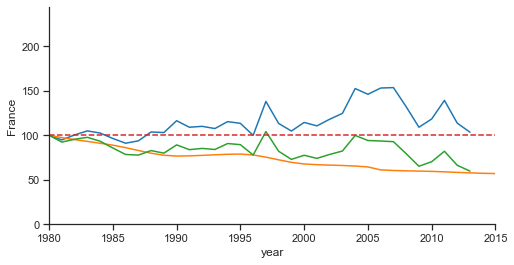

In [39]:
# Base 100 = 1980
FGProd_diff = (100 * BE_FR['Production [kt]'] 
               / BE_FR['Production [kt]'].loc[1980]
              )

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * BE_FR['CO2, flat glass [kt]'] 
               / BE_FR['CO2, flat glass [kt]'].loc[1980]
              )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = FGProd_diff, 
             x = FGProd_diff.index, 
             y = 'France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--')

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

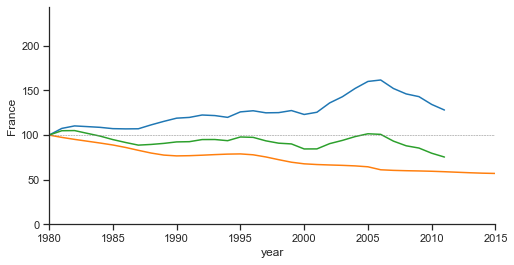

In [40]:
# Base 100 = 1980
FGProd_diff = (100 * (BE_FR['Production [kt]']
                      .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center=True).mean()) 
               / (BE_FR['Production [kt]']
                  .interpolate(method="linear", limit_area='inside')
                  .rolling(5, center = True).mean()).loc[1980])

CO2Intensity_diff = 100 * CO2_Intensity / CO2_Intensity.loc[1980]

CO2ABS_diff = (100 * (BE_FR['CO2, flat glass [kt]']
                     .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center = True).mean()) 
               / (BE_FR['CO2, flat glass [kt]']
                     .interpolate(method="linear", limit_area='inside')
                     .rolling(5, center=True).mean().loc[1980])
              )

# Plotting production, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data=FGProd_diff, 
             x=FGProd_diff.index, 
             y='France',
             ax=ax)

ax.plot(CO2Intensity_diff.index, 
        CO2Intensity_diff['CO2 interpolated [kg/t]'])
ax.plot(CO2ABS_diff.index, 
        CO2ABS_diff['France'])

ax.plot([1980, 2015], [100, 100], '--', c='grey', linewidth=0.5)

ax.set_xlim(1980,2015)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# Raw materials and energy use in the flat glass industry

## Material intensity since 1945

In [41]:
# Creating a DataFrame for material intensity
MatIntensity = FR_data.parse('RawMat_Intensity').set_index('year')

In [42]:
# Interpolating the raw material intensity dataset
MatIntensity = MatIntensity.interpolate(method='pchip',
                                         limit_direction='forward')

In [43]:
materials = ['internal cullet', 'external cullet', 'sand', 'sodium carbonate', 
             'sodium sulfate', 'limestone', 'dolomite', 'feldspar']

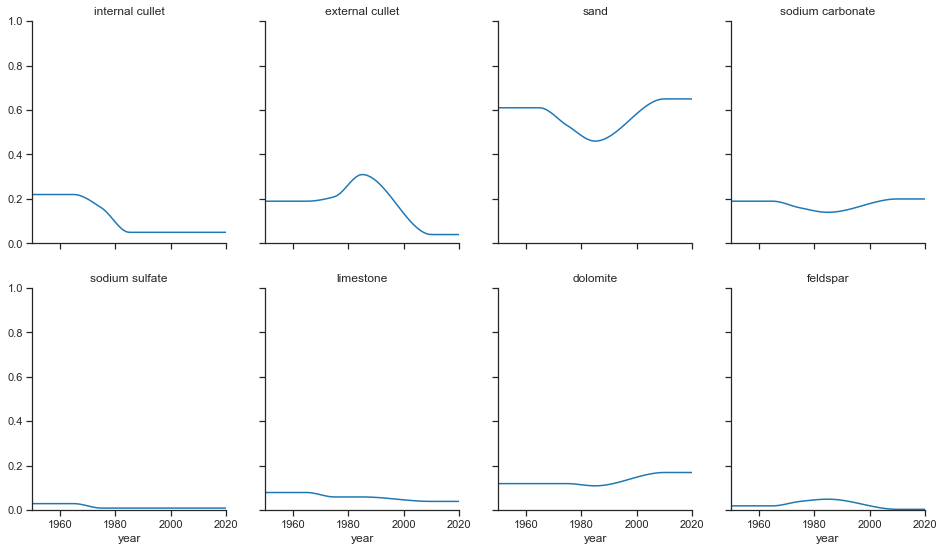

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=4,
                         sharex=True, sharey=True,
                         figsize=(16,9))

for i, (ax, mat) in enumerate(zip(axes.flatten(), materials)):

    ax.set_title(mat)
    MatIntensity[(f"{mat}, kg/kg")].plot(ax=ax)
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

In [45]:
MatIntensity['Total raw materials, kg/kg'] = 0

for mat in materials:
    MatIntensity['Total raw materials, kg/kg'] = (
        MatIntensity[(f"{mat}, kg/kg")] 
        + MatIntensity['Total raw materials, kg/kg']
    )

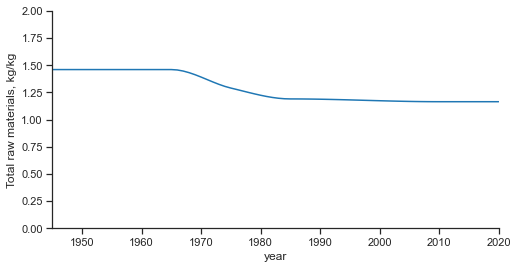

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = MatIntensity, 
             x = MatIntensity.index, 
             y = 'Total raw materials, kg/kg',
             ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,2)
sns.despine()
plt.show()

## Energy intensity since 1945

In [47]:
# Creating a DataFrame for energy intensity
EnergyIntensity = FR_data.parse('Energy_Intensity').set_index('year')

In [48]:
# Interpolating the raw material intensity dataset
EnergyIntensity = EnergyIntensity.interpolate(method='akima',
                                         limit_direction='forward')

In [49]:
energies = ['fuel', 'electricity', 'natural gas']

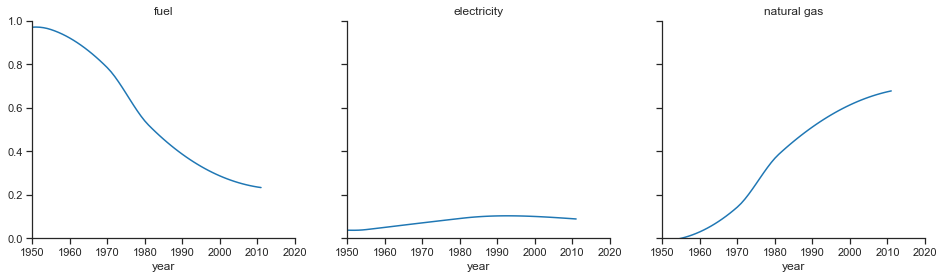

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3,
                         sharex=True, sharey=True,
                         figsize=(16,4))

for i, (ax, energy) in enumerate(zip(axes.flatten(), energies)):

    ax.set_title(energy)
    EnergyIntensity[(f"{energy}, %")].plot(ax=ax)
    
ax.set_xlim(1950,2020)
ax.set_ylim(0,1)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

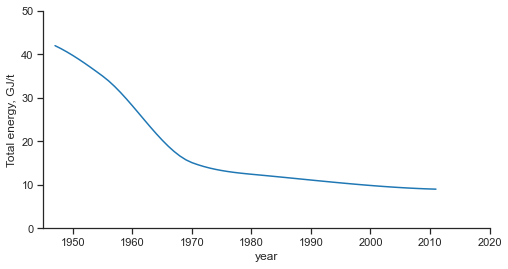

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = EnergyIntensity, 
             x = EnergyIntensity.index, 
             y = 'Total energy, GJ/t',
             ax=ax)

ax.set_xlim(1945,2020)
ax.set_ylim(0,50)
sns.despine()
plt.show()

## Use of raw materials in the production of flat glass

In [52]:
# Absolute use of raw materials for fat glass production:
for mat in materials:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{mat}, flat glass [kt]", country)] = (
            BE_FR[('Production [kt]', country)]
            * MatIntensity[(f"{mat}, kg/kg")]
        )

In [53]:
countries = ['Belgium', 'France']

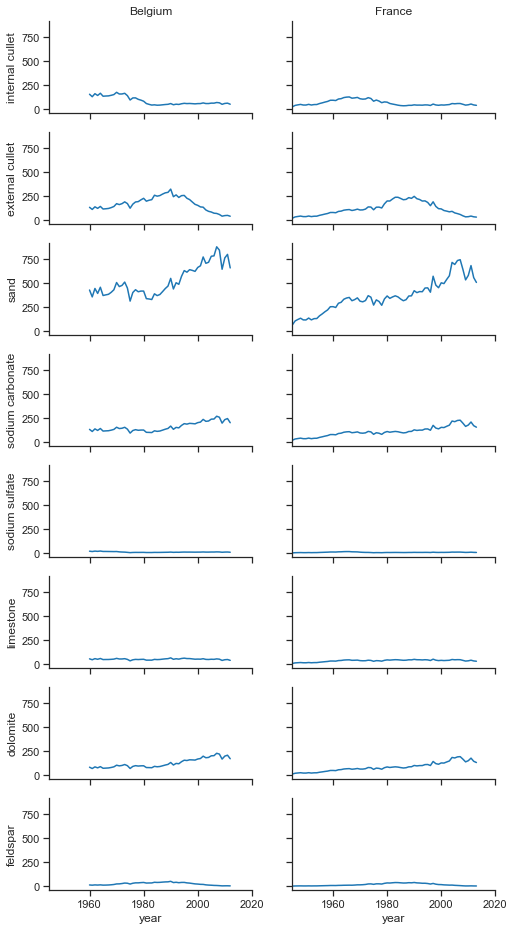

In [54]:
nrows = len(materials)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(8,16))
for row, material in enumerate(materials):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(material)
        BE_FR[(f"{material}, flat glass [kt]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

In [67]:
BE_FR['Total raw material use, flat glass [kt]'] = 0

for material in materials:
    BE_FR['Total raw material use, flat glass [kt]'] = (
        BE_FR[(f"{material}, flat glass [kt]", country)] 
        + BE_FR['Total raw material use, flat glass [kt]']
    )

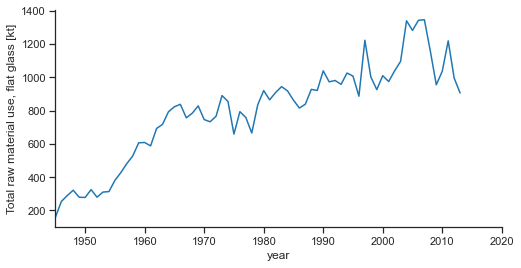

In [68]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total raw material use, flat glass [kt]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

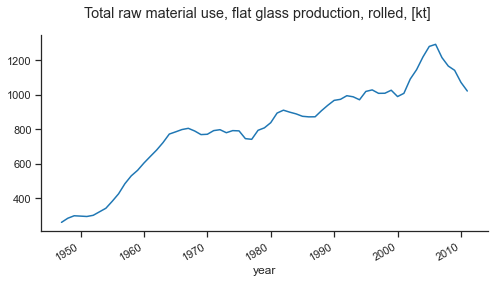

In [70]:
(BE_FR['Total raw material use, flat glass [kt]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total raw material use, flat glass production, rolled, [kt]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

## Energy Use in the production of flat glass

In [55]:
# Absolute use of energy for flat glass production:
for energy in energies:
    for country in BE_FR['Production [kt]'].columns:
        BE_FR[(f"{energy}, flat glass [TJ]", country)] = (
            BE_FR[('Production [kt]', country)]
            * EnergyIntensity[(f"{energy}, GJ/t")] 
        )

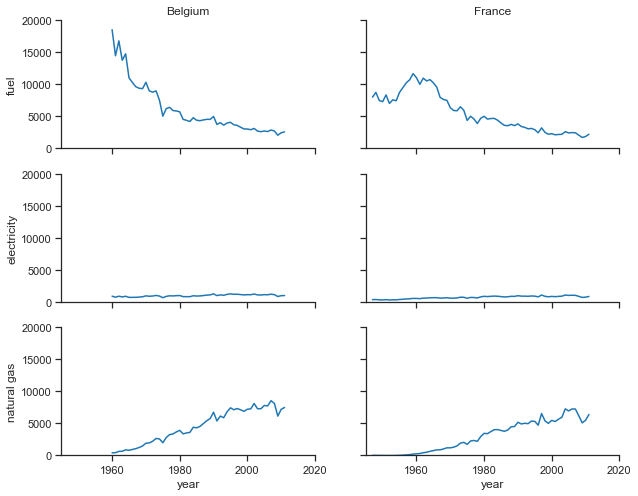

In [56]:
nrows = len(energies)
ncols = len(countries)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         sharex=True, sharey=True,
                         figsize=(10,8))
for row, energy in enumerate(energies):
    for col, country in enumerate(countries):
        ax = ax=axes[row][col]
        if row == 0:
            ax.set_title(country)
        if col == 0:
            ax.set_ylabel(energy)
        BE_FR[(f"{energy}, flat glass [TJ]", country)].plot(ax=ax)
        
ax.set_xlim(1945,2020)
ax.set_ylim(0,20000)

# Eventuellement: fig.tight_layout()

sns.despine()
plt.show()

In [57]:
BE_FR['Total energy use, flat glass [TJ]'] = 0

for energy in energies:
    BE_FR['Total energy use, flat glass [TJ]'] = (
        BE_FR[(f"{energy}, flat glass [TJ]", country)] 
        + BE_FR['Total energy use, flat glass [TJ]']
    )

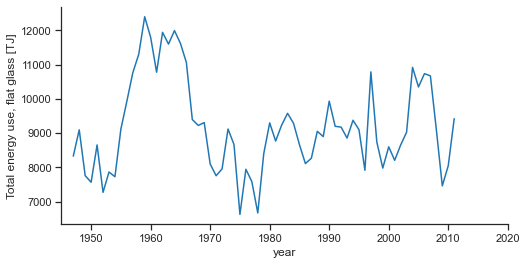

In [60]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(data = BE_FR, 
             x = BE_FR.index, 
             y = 'Total energy use, flat glass [TJ]',
             ax=ax)

ax.set_xlim(1945,2020)
sns.despine()
plt.show()

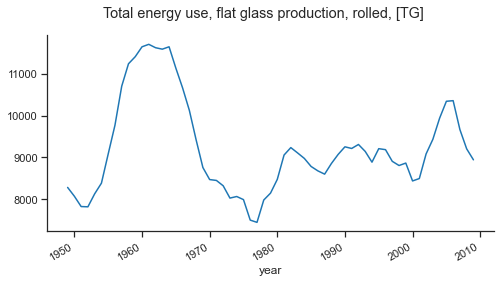

In [66]:
(BE_FR['Total energy use, flat glass [TJ]']
 .rolling(5, center = True)
 .mean()).plot(subplots=True, 
               grid=False, 
               figsize=(8, 4),
               sharex=True, sharey=True,
               title=
               ("Total energy use, flat glass production, rolled, [TG]")
              )
    
ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# Insulated glazing flows in France

In [ ]:
# Creating a new DataFrame for French IGU
FR_IGU = FR_Prod[['IGU, "000 m²']]
FR_IGU = FR_IGU.rename(columns={'IGU, "000 m²':'prod ["000 m²]'})

FR_IGU['import ["000 m²]'] = FR_Imp['IGU, "000 m²']
FR_IGU['export ["000 m²]'] = FR_Exp['IGU, "000 m²']

FR_IGU['consumption ["000 m²]'] \
    = FR_IGU['prod ["000 m²]'] + FR_IGU['import ["000 m²]'] \
    - FR_IGU['export ["000 m²]']

FR_IGU[-10:]

In [ ]:
sns.scatterplot(data=FR_IGU, palette='colorblind')
sns.despine()
plt.show()

In [ ]:
FR_IGU['prod interpolated ["000 m²]'] = FR_IGU['prod ["000 m²]'].interpolate(method = 'pchip')

toplot = FR_IGU.reset_index()
sns.scatterplot(data=toplot, x='year', y='prod interpolated ["000 m²]')
sns.despine()
plt.show()

In [ ]:
# Estimating consumption/production ratio over the period 1995-2000
FR_IGU['consumption/production [-]'] \
    = FR_IGU['consumption ["000 m²]'] / FR_IGU['prod ["000 m²]']

a = FR_IGU.loc[1995:2000, 'consumption/production [-]'].mean().round(2)
print("Mean consumption/production ratio, 1995-2000:", a)

FR_IGU['consumption/production [-]'][1945] = 0
FR_IGU.head()

In [ ]:
# Estimating consumption since 1945
filt_null = FR_IGU['consumption ["000 m²]'].isnull()

FR_IGU.loc[filt_null, 'consumption ["000 m²]'] \
    = FR_IGU.loc[filt_null, 'prod interpolated ["000 m²]']

FR_IGU = FR_IGU.reset_index()

fig, ax = plt.subplots()

# lineplot is useless here. In fact you should use dataframe.plot() for both...
sns.lineplot(data=FR_IGU, x='year', y='prod interpolated ["000 m²]',
             ax=ax, palette='Reds')

ax.plot(FR_IGU['year'], FR_IGU['consumption ["000 m²]'], color='firebrick')

FR_IGU = FR_IGU.set_index('year')
sns.despine()
plt.show()

In [ ]:
# Rolling IGU consumption data according to a 5-year mean
FR_IGU_roll = FR_IGU[['consumption ["000 m²]']].copy()

win_len = 5
FR_IGU_roll = FR_IGU_roll.rolling(win_len, center = True).mean()

# Plotting results, to be compared with above graph
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_roll, palette="GnBu")

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)

fig.suptitle('IGU (rolled) [kt/y]', 
             fontsize = 20)

## c. CO2 emissions relating to IGU consumption in FR

In [ ]:
# Hypothesis: The average thickness of an IGU is twice 4mm, 
# i.e., 8mm of glass, which equals 20kg per m²
FR_IGU['consumption [kt]'] = FR_IGU['consumption ["000 m²]'] * 20 / 1000

# Absolute CO2 emissions in France
CO2_IGU = FR_IGU['consumption [kt]'] \
    * CO2_Intensity['CO2 interpolated [kg/t]'] / 1000

CO2_IGU = pd.DataFrame(CO2_IGU, columns = ['IGU CO2 [kt]'])

# Plotting
sns.lineplot(data = CO2_IGU)

sns.despine()
plt.show()

In [ ]:
# Rolling CO2 emissions of IGU according to a 5-year mean
win_len = 5
CO2_IGU_roll = CO2_IGU.rolling(win_len, center = True).mean()

# Plotting
fig, ax = plt.subplots()

sns.lineplot(data = CO2_IGU_roll)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

In [ ]:
# Base 100 = 1990
CO2_IGU_diff_roll = 100 * CO2_IGU_roll / CO2_IGU_roll.loc[1980]
FR_IGU_diff_roll = 100 * FR_IGU_roll / FR_IGU_roll.loc[1980]

# Plotting consumption, carbon intensity, CO2 absolute emissions for France
fig, ax = plt.subplots()

sns.lineplot(data = FR_IGU_diff_roll, 
             x = FR_IGU_diff_roll.index, 
             y = 'consumption ["000 m²]',
             palette = "GnBu")

ax.plot(CO2Intensity_diff_noroll.index, 
        CO2Intensity_diff_noroll['CO2 interpolated [kg/t]'])
ax.plot(CO2_IGU_diff_roll.index, 
        CO2_IGU_diff_roll['IGU CO2 [kt]'])

ax.plot([1980, 2020], [100, 100], '--')

ax.set_xlim(1980,2020)
ax.set_ylim(ymin=0)
sns.despine()
plt.show()

# 3. Postprocessing of the European dataset

## a. Production of flat glass

In [ ]:
EU_Prod = EU_data.parse('prod').set_index(['Nbr of countries', 'year'])
EU_Prod

In [ ]:
# Plot the European production of flat glass

EUplot = EU_Prod.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European production of flat glass [kt/y]', fontsize = 20)
sns.despine()
plt.show()

In [ ]:
# Adding import and export in order to estimate consumption in EU
EU_Imp = EU_data.parse('import').set_index(['Nbr of countries', 'year'])
EU_Exp = EU_data.parse('export').set_index(['Nbr of countries', 'year'])

# Estimating consumption in EU
EU_Consumption = EU_Prod.reset_index()[['Nbr of countries', 
                                        'year']].set_index(['Nbr of countries', 
                                                            'year'])
EU_Consumption['flat glass, kt'] = EU_Prod['flat glass, kt'] \
    + EU_Imp['flat glass, kt'] - EU_Exp['flat glass, kt']

# Plot the European consumption of flat glass

EUplot = EU_Consumption.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data = EUplot, x = 'year', y = 'flat glass, kt', 
             hue = 'Nbr of countries', 
             palette = 'colorblind',
             ax = ax)

ax.set_xlim(1945,2020)
ax.set_ylim(ymin=0)
fig.suptitle('European consumption of flat glass [kt/y]', fontsize = 20)
sns.despine()
plt.show()

## c. Production of architectural flat glass

In [ ]:
# Share of building glazing in the European production of flat glass
EUBldgShare = EU_Prod[['bldg glass/flat glass, %']]

ShareEU = EUBldgShare.dropna()
ShareEU

In [ ]:
toplot = EUBldgShare.reset_index()

fig, ax = plt.subplots()

sns.lineplot(data=toplot, x='year', y='bldg glass/flat glass, %', 
             markers="o", ax=ax)

ax.lines[0].set_linestyle("--")
ax.set_xlim(1945,2020)
ax.set_ylim(0,1)

In [ ]:
EUBldgShare

In [ ]:
# Estimating parameters a, b and c; 2-degree polynomial
values = np.polyfit(x=ShareEU.index.get_level_values(0), 
                  y=ShareEU['bldg glass/flat glass, %'], 
                  deg=2, full=True) 

values

In [ ]:
# Interpolation according to values calculated above
EUBldgShare.loc[1970:2020, 'bldg glass/flat glass (interpolated) [%]'] \
    = values[0][0] * EUBldgShare.index(0) ** 2\
    * values[0][1] * EUBldgShare.index(0) \
    * values[0][2] * EUBldgShare.index(0)

EUBldgShare[-50:]

In [ ]:
fig, ax = plt.subplots()

sns.scatterplot(data=EUBldgShare,
                x='year', 
                y='bldg glass/flat glass (interpolated) [%]',
                ax=ax)

ax.lines[0].set_linestyle("--")
ax.set_xlim(1945,2020)
ax.set_ylim(0,1)